# Importing Libraries


In [1]:
from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

Finished!


In [2]:
import copy 
import numpy as np

import torch 
import numpy as np 

import torch 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset 

from data_generation.square_sequences import generate_sequences 
from stepbystep.v4 import StepByStep 

# Part 1

# Sequence-to-Sequence

## Data Generation

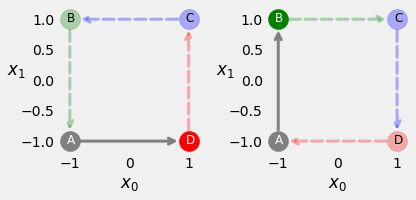

In [3]:
fig = counter_vs_clock(binary=False)

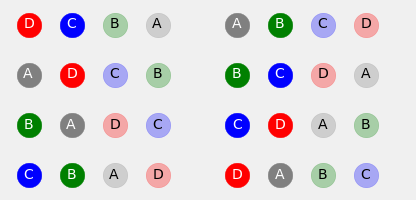

In [4]:
fig = plot_sequences(binary=False, target_len=2)

In [5]:
points, directions = generate_sequences(n=256, seed=13)

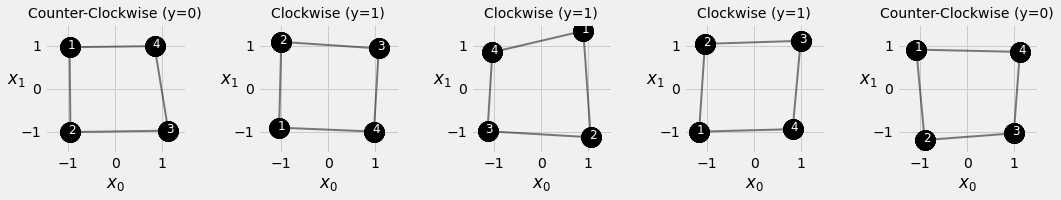

In [6]:
fig = plot_data(points, directions, n_rows=1)

# Encoder-Decoder Architecture

## Encoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder.png?raw=1)

In [7]:
class Encoder(nn.Module):
  def __init__(self, n_features, hidden_dim):
    super().__init__()
    self.hidden_dim = hidden_dim 
    self.n_features = n_features 
    self.hidden = None 
    self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)

  def forward(self, X):
    rnn_out, self.hidden = self.basic_rnn(X)


    return rnn_out # N, L, F

In [8]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2] # first two corners
target_seq = full_seq[:, 2:] # last two corners

In [9]:
full_seq

tensor([[[-1., -1.],
         [-1.,  1.],
         [ 1.,  1.],
         [ 1., -1.]]])

In [10]:
source_seq

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [11]:
target_seq

tensor([[[ 1.,  1.],
         [ 1., -1.]]])

In [12]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq) # output is N, L, F
hidden_final = hidden_seq[:, -1:] # takes last hidden state 
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

In [13]:
hidden_seq

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

## Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/decoder.png?raw=1)

In [14]:
class Decoder(nn.Module):
  def __init__(self, n_features, hidden_dim):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.n_features = n_features 
    self.hidden = None 
    self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
    self.regression = nn.Linear(self.hidden_dim, self.n_features)

  def init_hidden(self, hidden_seq):
    # We only need the final hidden state 
    hidden_final = hidden_seq[:, -1:] # N, L, H 
    # But we need to make it sequence-first
    self.hidden = hidden_final.permute(1, 0, 2) # 1, N, H 

  def forward(self, X):
    # X is N, 1, F 
    batch_first_output, self.hidden = self.basic_rnn(X, self.hidden)

    last_output = batch_first_output[:, -1:]
    out = self.regression(last_output)

    # N, 1, F
    return out.view(-1, 1, self.n_features)

In [15]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be decoder's final hidden state 
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequance 
inputs = source_seq[:, -1:]


target_len = 2
for i in range(target_len):
  print(f'Hidden: {decoder.hidden}')
  out = decoder(inputs) # Predicts coordinates
  print(f'Output: {out}\n')
  # Predicted coordinates are next step inputs
  inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



## Teacher Forcing

In [16]:
# Initial hidden state will be encoder's final hidden state 
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
  print(f'Hidden: {decoder.hidden}')
  out = decoder(inputs) # Predicts coordinates
  print(f'Output: {out}\n')
  # But completely ignores the predictions and uses real data instead
  inputs = target_seq[:, i:i+1]

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward0>)



## Encoder + Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_decoder.png?raw=1)

In [17]:
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
    super().__init__()
    self.encoder = encoder 
    self.decoder = decoder 
    self.input_len = input_len 
    self.target_len = target_len 
    self.teacher_forcing_prob = teacher_forcing_prob 
    self.outputs = None 

  def init_outputs(self, batch_size):
    device = next(self.parameters()).device
    # N, L (target), F
    self.outputs = torch.zeros(batch_size, self.target_len, self.encoder.n_features).to(device)

  def store_output(self, i, out):
    # Stores the output 
    self.outputs[:, i:i+1, :] = out 

  def forward(self, X):
    # splits the data in source and target sequences
    # the target seq will be empty in testing mode 
    # N, L, F
    source_seq = X[:, :self.input_len, :]
    target_seq = X[:, self.input_len:, :]
    self.init_outputs(X.shape[0])

    # Encoder 
    hidden_seq = self.encoder(source_seq)
    # Output is N, L, H 
    self.decoder.init_hidden(hidden_seq)

    
    # The last input of the encoder is also 
    # the first input of the decoder 
    dec_inputs = source_seq[:, -1:, :]

    # Generates as many outputs as the target length 
    for i  in range(self.target_len):
      # Output of decoder is N, 1, F
      out = self.decoder(dec_inputs)
      self.store_output(i, out)

      prob = self.teacher_forcing_prob 
      # In evaluation/test the target sequence is 
      # unknown, so we cannot use teacher forcing 
      if not self.training:
        prob = 0

      # If it is a teacher forcing 
      if torch.rand(1) <= prob:
        # Takes the actual element
        dec_inputs = target_seq[:, i:i+1, :]

      else:
        # Otherwise uses the last predicted output
        dec_inputs = out 

    return self.outputs



In [18]:
encdec = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=1.0)

In [19]:
encdec.train()
encdec(full_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.2265,  0.4529]]], grad_fn=<CopySlices>)

### Data Preparation

In [20]:
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

<ipython-input-20-a9562b08ddee>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  full_train = torch.as_tensor(points).float()


In [21]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [22]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Training and Configuration

In [23]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [24]:
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

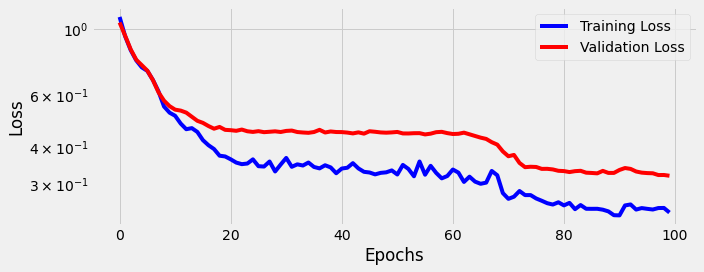

In [25]:
fig = sbs_seq.plot_losses()

### Visualizing the Predictions

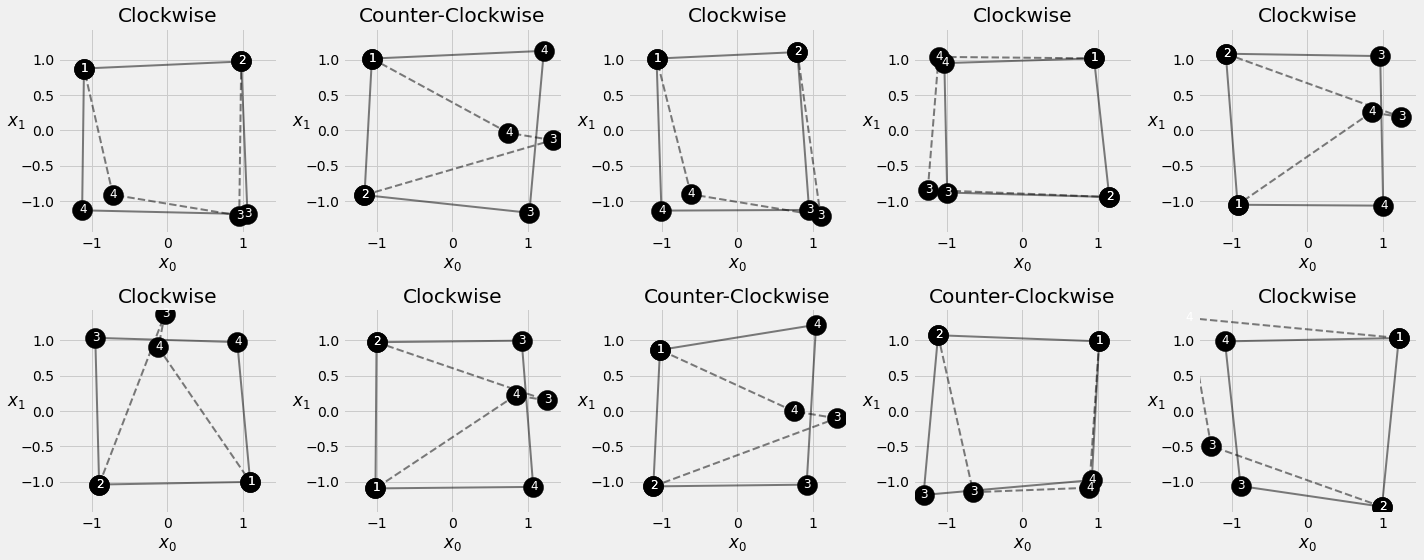

In [26]:
fig = sequence_pred(sbs_seq, full_test, test_directions)

## Attention

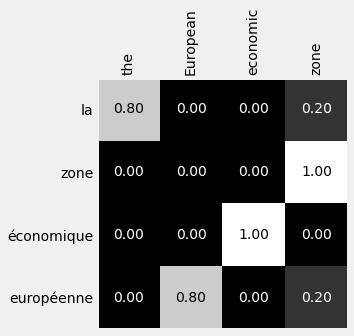

In [27]:
fig = figure9()

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/enc_dec_attn_translate.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/context_translate.png?raw=1)

### ""Values""

$$
\large
\text{context vector} = \underbrace{\alpha_0 * h_0}_{\text{alignment vector}_0} + \underbrace{\alpha_1 * h_1}_{\text{alignment vector}_1} = 0.8 * \text{value}_{the} + 0.2 *\text{value}_{zone}
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/kq_matches.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/score_alignment_translate.png?raw=1)

### Computing the Context Vector

In [28]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [29]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)

values = hidden_seq # N, L, H 
values


tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [30]:
keys = hidden_seq # N, L, H 
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [31]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)

inputs = source_seq[:, -1:]
out = decoder(inputs)

In [32]:
query = decoder.hidden.permute(1, 0, 2) # N, 1, H
query

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward0>)

In [33]:
def calc_alphas(ks, q):
  N, L, H = ks.size()
  alphas = torch.ones(N, 1, L).float() * 1/L
  return alphas 


alphas = calc_alphas(keys, query) 
alphas

tensor([[[0.5000, 0.5000]]])

$$
\Large
(\color{green}{N}\color{black}, 1, \color{red}{L}\color{black}) \times 
(\color{green}{N}\color{black}, \color{red}{L}\color{black}, H) = 
(\color{green}{N}\color{black}, 1\color{black}, H)
$$


In [34]:
# (N, 1, L) x (N, L, H) -> (1, L) x (L, H) -> (1, H) 
context_vector = torch.bmm(alphas, values) 
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

In [35]:
concatenated = torch.cat([context_vector, query], axis=-1)
concatenated

tensor([[[ 0.1968, -0.2809,  0.3913, -0.6853]]], grad_fn=<CatBackward0>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_attn.png?raw=1)

### Scoring Method

$$
\Large
\text{cos}\ \theta = \frac{\sum_i{q_ik_i}}{\sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}}
$$

$$
\Large
\text{cos}\ \theta \sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}= \sum_i{q_ik_i}
$$

$$
\Large
\text{cos}\ \theta\ ||Q||\ ||K|| = Q \cdot K
$$

In [36]:
# (N, 1, H) x (N, H, L) -> (N, 1, L)
products = torch.bmm(query, keys.permute(0, 2, 1))
products 

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)

### Attension Scores

In [37]:
alphas = F.softmax(products, dim=-1)
alphas

tensor([[[0.3953, 0.6047]]], grad_fn=<SoftmaxBackward0>)

In [38]:
def calc_alphas(ks, q):
  # (N, 1, H) x (N, H, L) -> (N, 1, L)
  products = torch.bmm(q, ks.permute(0, 2, 1))
  alphas = F.softmax(products, dim=-1)
  return alphas

###**Visualizing the Context Vector** 


In [39]:
q = torch.tensor([.55, .99]).view(1, 1, 2) # N, 1, H
k = torch.tensor([[.65, .2], 
                 [.85, -.4],
                 [-.95, -.75]]).view(1, 3, 2) # N, L, H

In [40]:
print(q)

tensor([[[0.5500, 0.9900]]])


In [41]:
print(q.squeeze())

tensor([0.5500, 0.9900])


In [42]:
print(k)

tensor([[[ 0.6500,  0.2000],
         [ 0.8500, -0.4000],
         [-0.9500, -0.7500]]])


In [43]:
print(k.view(3, 2))

tensor([[ 0.6500,  0.2000],
        [ 0.8500, -0.4000],
        [-0.9500, -0.7500]])


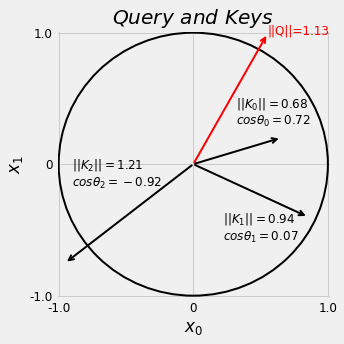

In [44]:
fig = query_and_keys(q.squeeze(), k.view(3, 2))

$$
\Large
\begin{array}
&Q \cdot K_0 = cos \theta_0\ ||Q||\ ||K_0|| =& &0.73 &*& 1.10 &*& 0.68 =& &0.54
\\
Q \cdot K_1 = cos \theta_1\ ||Q||\ ||K_1|| =& &0.08 &*& 1.10 &*& 0.94 =& &0.08
\\
Q \cdot K_2 = cos \theta_2\ ||Q||\ ||K_2|| =& -&0.93 &*& 1.10 &*& 1.21 =& -&1.23
\end{array}
$$

In [45]:
print(q), print(k.permute(0, 2, 1))

tensor([[[0.5500, 0.9900]]])
tensor([[[ 0.6500,  0.8500, -0.9500],
         [ 0.2000, -0.4000, -0.7500]]])


(None, None)

In [46]:
# (N, 1, H) x (N, H, L) -> (N, 1, L)
prod = torch.bmm(q, k.permute(0, 2, 1))
prod

tensor([[[ 0.5555,  0.0715, -1.2650]]])

In [47]:
scores = F.softmax(prod, dim=-1)
scores

tensor([[[0.5623, 0.3466, 0.0911]]])

In [48]:
print(scores, v)

NameError: ignored

$$
\Large
\text{context vector}=
0.5557*
\begin{bmatrix}
0.65
\\
0.20
\end{bmatrix}
+
0.3508*
\begin{bmatrix}
\ \ 0.85
\\
-0.40
\end{bmatrix}
+
0.0935*
\begin{bmatrix}
-0.95
\\
-0.75
\end{bmatrix}
$$

In [49]:
v = k
context = torch.bmm(scores, v)
context

tensor([[[ 0.5736, -0.0945]]])

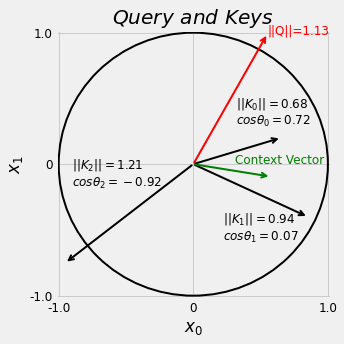

In [50]:
fig = query_and_keys(q.squeeze(), k.view(3, 2), context)

### Scaled Dot Product

$$
\Large
\text{scaled dot product} = \frac{Q \cdot K}{\sqrt{d_k}}
$$

In [51]:
print(query, query.size(-1))

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward0>) 2


In [52]:
dims = query.size(-1)

In [53]:
dims

2

In [54]:
print(products), print(np.sqrt(dims))

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)
1.4142135623730951


(None, None)

In [55]:
scaled_products = products/np.sqrt(dims)
scaled_products

tensor([[[0.0403, 0.3409]]], grad_fn=<DivBackward0>)

In [56]:
dummy_product = torch.tensor([4.0, 1.0])
F.softmax(dummy_product, dim=-1), F.softmax(100*dummy_product, dim=-1)

(tensor([0.9526, 0.0474]), tensor([1., 0.]))

In [57]:
alphas = F.softmax(scaled_products, dim=-1)
alphas

tensor([[[0.4254, 0.5746]]], grad_fn=<SoftmaxBackward0>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/aiayn_dot.png?raw=1)

In [58]:
n_dims = 10
vector1 = torch.randn(10000, 1, n_dims)
vector2 = torch.randn(10000, 1, n_dims).permute(0, 2, 1)
torch.bmm(vector1, vector2).squeeze().var()

tensor(9.7670)

In [59]:
print(vector1, vector2)

tensor([[[ 0.0311, -0.6342, -0.0893,  ...,  0.4677, -1.3913, -0.1793]],

        [[ 0.8253,  0.5144, -0.3077,  ...,  1.2961,  0.1743, -0.8399]],

        [[ 1.7487,  1.3569, -0.8224,  ...,  0.1432,  0.3475, -0.7117]],

        ...,

        [[ 1.1777, -0.0819, -0.1311,  ...,  1.6304, -0.8590,  1.6200]],

        [[-0.6022, -0.9755,  1.0272,  ..., -1.0348,  0.0552, -0.3701]],

        [[ 0.7650,  0.0611,  0.1026,  ...,  0.2794,  1.2987, -0.4395]]]) tensor([[[ 0.0368],
         [ 0.6896],
         [ 0.3568],
         ...,
         [-1.2447],
         [ 1.1989],
         [-0.2721]],

        [[-1.0563],
         [-0.3773],
         [ 0.4994],
         ...,
         [-0.7286],
         [ 0.3298],
         [ 0.0815]],

        [[ 0.3382],
         [ 0.1215],
         [-0.0383],
         ...,
         [-0.0092],
         [-0.8858],
         [-0.6096]],

        ...,

        [[ 1.4386],
         [ 0.7279],
         [-0.0105],
         ...,
         [-0.3126],
         [-0.3334],
         [-0

$$
\Large
\text{Var}(\text{vector}_1 \cdot \text{vector}_2) = d_{\text{vector}_1} = d_{\text{vector}_1}
\\
\Large
\sigma(\text{vector}_1 \cdot \text{vector}_2) = \sqrt{d_{\text{vector}_1}} = \sqrt{d_{\text{vector}_2}}
$$

In [60]:
def calc_alphas(ks, q):
  dims = q.size(-1)
  # (N, 1, H) x (N, H, L) -> (N, 1, L)
  products = torch.bmm(q, ks.permute(0, 2, 1))
  scaled_products = products/np.sqrt(dims)
  alphas = F.softmax(scaled_products, dim=-1)
  return alphas

In [61]:
alphas = calc_alphas(keys, query)
# (N, 1, L) x (N, L, H) -> (1, L, L, H) -> (1, H)
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.2138, -0.3175]]], grad_fn=<BmmBackward0>)

In [62]:
print(alphas, values)

tensor([[[0.4254, 0.5746]]], grad_fn=<SoftmaxBackward0>) tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)


### Attention Mechanism

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attention.png?raw=1)

In [63]:
class Attention(nn.Module):
  def __init__(self, hidden_dim, input_dim=None, proj_values=False):
    super().__init__()
    self.d_k = hidden_dim 
    self.input_dim = hidden_dim if input_dim is None else input_dim 
    self.proj_values = proj_values 
    # Affine transformations for Q, K and V
    self.linear_query = nn.Linear(self.input_dim, hidden_dim)
    self.linear_key = nn.Linear(self.input_dim, hidden_dim)
    self.linear_value = nn.Linear(self.input_dim, hidden_dim)
    self.alphas = None 

  def init_keys(self, keys):
    self.keys = keys 
    self.proj_keys = self.linear_key(self.keys)
    self.values = self.linear_values(self.keys) if self.proj_values else self.keys

  def score_function(self, query):
    proj_query = self.linear_query(query)
    # scaled dot products 
    # (N, 1, H) x (N, H, L) -> (N, 1, L)
    dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
    scores = dot_products / np.sqrt(self.d_k)
    return scores 

  def forward(self, query, mask=None):
    # Query is batch-first (N, 1, H)
    scores = self.score_function(query) # (N, 1, L)
    if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)
    alphas = F.softmax(scores, dim=-1) # (N, 1, L)
    self.alphas = alphas.detach()
    

    # (N, 1, L) x (N, L, H) -> (N, 1, H)
    context = torch.bmm(alphas, self.values)
    return context

### Source Mask

In [64]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
# pretend there's an encoder here ......
keys = torch.tensor([[[-.38, .44], [.85, -.05]]])
query = torch.tensor([[[-.1, 1.]]])

In [65]:
source_mask = (source_seq != 0).all(axis=2).unsqueeze(1)
source_mask # (N, 1, L) 

tensor([[[ True, False]]])

In [66]:
torch.manual_seed(11)
attnh = Attention(2)
attnh.init_keys(keys)

context = attnh(query, mask=source_mask) 
attnh.alphas

tensor([[[1., 0.]]])

### Decoder

In [67]:
class DecoderAttn(nn.Module):
  def __init__(self, n_features, hidden_dim):
    super().__init__()
    self.hidden_dim = hidden_dim 
    self.n_features = n_features 
    self.hidden = None
    self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
    self.attn = Attention(self.hidden_dim)
    self.regression = nn.Linear(2 * self.hidden_dim, self.n_features)

  def init_hidden(self, hidden_seq):
    # the output of the encoder is (N, L, H)
    # and init_keys expects batch-first as well 
    self.attn.init_keys(hidden_seq)
    hidden_final = hidden_seq[:, -1:]
    self.hidden = hidden_final.permute(1, 0, 2) # (L, N, H)

  def forward(self, X, mask=None):
    # X is (N, 1, F)
    batch_first_output, self.hidden = self.basic_rnn(X, self.hidden)

    query = batch_first_output[:, -1:]
    # Attention 
    context = self.attn(query, mask=mask)
    concatenated = torch.cat([context, query], axis=-1)
    out = self.regression(concatenated) 


    # (N, 1, F)
    return out.view(-1, 1, self.n_features)



In [68]:
full_seq = torch.tensor([[[-1, -1], [-1, 1], [1, 1], [1, -1]]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]
print(full_seq, source_seq, target_seq)

tensor([[[-1., -1.],
         [-1.,  1.],
         [ 1.,  1.],
         [ 1., -1.]]]) tensor([[[-1., -1.],
         [-1.,  1.]]]) tensor([[[ 1.,  1.],
         [ 1., -1.]]])


In [69]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)

# Generates hidden states (keys and values)
hidden_seq = encoder(source_seq)
decoder_attn.init_hidden(hidden_seq)

# Target sequence generation
inputs = source_seq[:, -1:]
target_len = 2
for i in range(target_len):
  out = decoder_attn(inputs)
  print(f'Output:{out}')
  inputs = out 

Output:tensor([[[-0.3555, -0.1220]]], grad_fn=<ViewBackward0>)
Output:tensor([[[-0.2641, -0.2521]]], grad_fn=<ViewBackward0>)


### Encoder + Decoder + Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_attn.png?raw=1)

In [70]:
encdec = EncoderDecoder(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.0)
encdec(full_seq)

tensor([[[-0.3555, -0.1220],
         [-0.2641, -0.2521]]], grad_fn=<CopySlices>)

In [74]:
class EncoderDecoderAttn(EncoderDecoder):
  def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
    super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
    self.alphas = None

  def init_outputs(self, batch_size):
    device = next(self.parameters()).device
    # N, L (target), F
    self.outputs = torch.zeros(batch_size, self.target_len, self.encoder.n_features).to(device)

    # N, L (target), L (source)
    self.alphas = torch.zeros(batch_size, self.target_len, self.input_len).to(device)
    def store_output(self, i, out):
      # Stores the output
      self.outputs[:, i:i+1, :] = out
      self.alphas[:, i:i+1, :] = self.decor.attn.alphas

### Model Training & Configuration

In [75]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)
model = EncoderDecoderAttn(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [76]:
sbs_seq_attn = StepByStep(model, loss, optimizer)
sbs_seq_attn.set_loaders(train_loader, test_loader)
sbs_seq_attn.train(100)


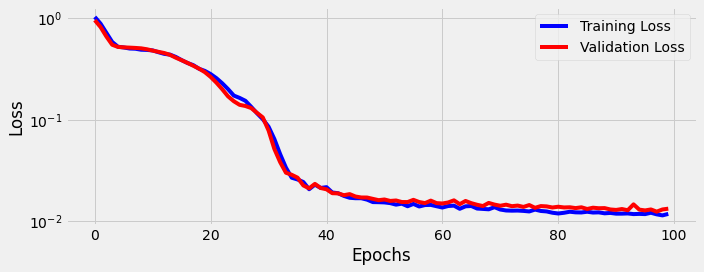

In [77]:
fig = sbs_seq_attn.plot_losses()

### Visualizing Predictions

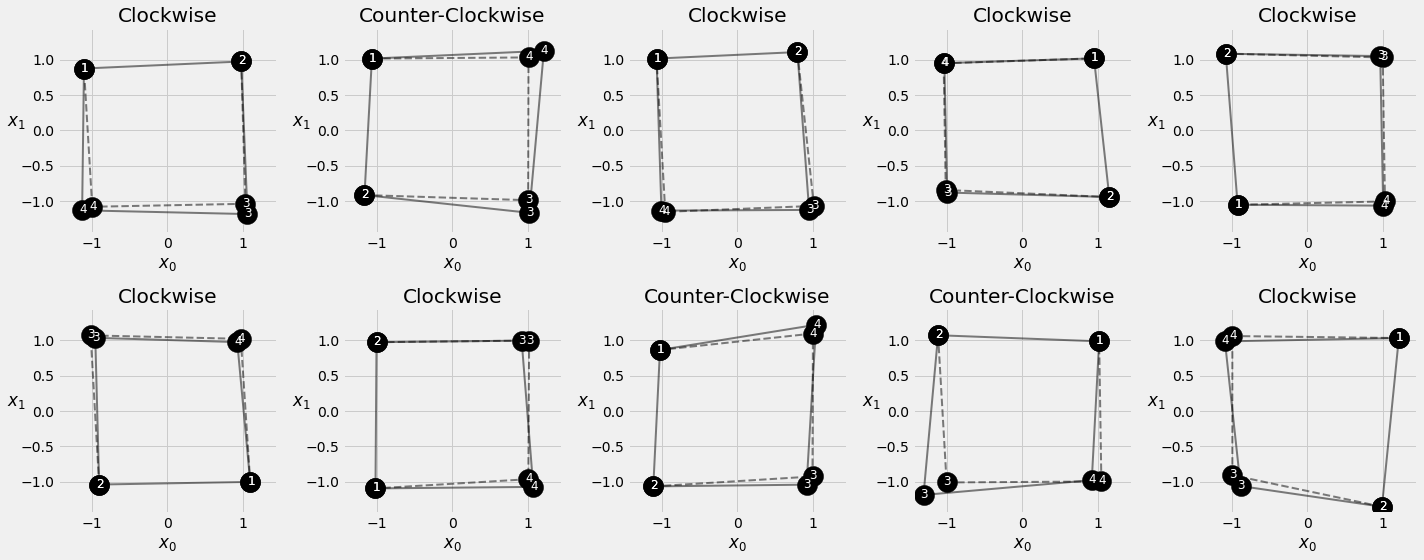

In [78]:
fig = sequence_pred(sbs_seq_attn, full_test, test_directions)

### Visualizing Attention

In [80]:
inputs = full_train[:1, :2]
out = sbs_seq_attn.predict(inputs)
sbs_seq_attn.model.alphas

tensor([[[0., 0.],
         [0., 0.]]])

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & \alpha_{\color{green}{2}\color{red}0} & \alpha_{{\color{green}{2}\color{red}1}} \\
 \color{green}{x_3} & \alpha_{\color{green}{3}\color{red}0} & \alpha_{{\color{green}{3}\color{red}1}}
\end{array}
\implies
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & 0.8196 & 0.1804\\
 \color{green}{x_3} & 0.7316 & 0.2684
\end{array}
$$

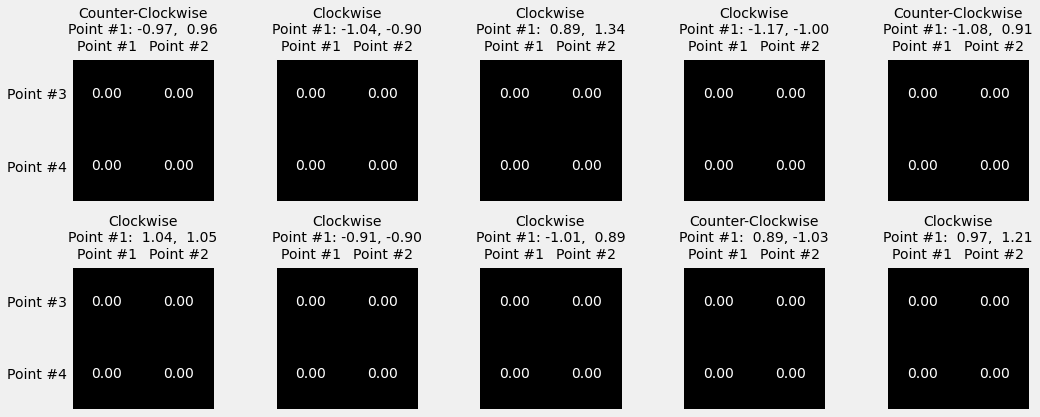

In [81]:
inputs = full_train[:10, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]: .2f}, {inp[0, 1]: .2f}' for i, inp in enumerate(inputs)]
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels)

### Multi Headed Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/multiattn.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/aiayn_multihead.png?raw=1)

In [82]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
    super().__init__()
    self.linear_out = nn.Linear(n_heads * d_model, d_model)
    self.attn_heads = nn.ModuleList([Attention(d_model, input_dim=input_dim, proj_values=proj_values) for _ in range(n_heads)])

  def init_keys(self, key):
    for attn in self.attn_heads:
      attn.init_keys(key)
    
  @property
  def alphas(self):
    # Shape: n_heads, (N, 1, L) (source)
    return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)

  def output_function(self, contexts):
    # (N, 1, n_heads) * D
    concatenated = torch.cat(contexts, axis=-1)
    # Linear transf. to go back to original dimension
    out = self.linear_out(concatenated) # (N, 1, D)
    return out 

  def forward(self, query, mask=False):
    contexts = [attn(query, mask=mask) for attn in self.attn_heads]
    out = self.output_function(contexts)
    return out
